<a href="https://colab.research.google.com/github/jordivg1/ARAP/blob/main/Copia_de_WindyGridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Margarita Cabrera-Bean, Josep Vidal

Alumne: Jordi Vaccher Gómez

# WINDY GRID WORLD
[Open to access description of tasks](https://drive.google.com/file/d/1wVWxRwIfRSfhdicwuWKSorav-BmC7Thh/view?usp=sharing)

1. Complete the code for each algorithm (Sarsa, Q-Learning, Expected Sarsa and Double Q-Learning).
2. Modify the environment creatively following the description of tasks document


In [72]:
import numpy as np
import seaborn as sns

from random import random, randint
import matplotlib.pyplot as plt
algs = ['SARSA', 'Q-LEARNING', 'EXPECTED SARSA', 'DOUBLE Q-LEARNING']

In [73]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 5000
        # left/down/right/up action
        # self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        self.ACTIONS = [(0, -1),(-1, -1) ,(1, 0), (1, 1), (0, 1), (1, -1) ,(-1, 0), (-1, 1)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final state
        self.INI_STATE = 6
        self.FIN_STATE = 76
        self.CLIFF_STATE = (67,45,74,55,37)

        # Define wind for each row and column
        # self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_V = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.WIND_H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes    
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]

        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)
        
        next_state = (row, col)

        next_state = self.get_state(next_state)

        if next_state == self.FIN_STATE:
            return next_state, 0
        elif next_state in self.CLIFF_STATE:
            return next_state, -50
        return next_state, -1

    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''
    def sarsa(self, state, action):
        
        # sarsa uses greedy policy for next action too

                      
        next_state,reward=self.next_position(state, action)
        next_action=self.greedy_policy(next_state)         

        self.Q_FUN[state,action]+= self.ALPHA*(reward+self.GAMMA*self.Q_FUN[next_state,next_action] - self.Q_FUN[state,action])

        #
        return next_state, next_action

    def q_learning(self, state, action):

        # q-learning always pick next_action with maximum action-value (q-value)

        # TODO
        action=self.greedy_policy(state)
        
        next_state,reward=self.next_position(state, action)                    
        self.Q_FUN[state,action] += self.ALPHA*(reward+self.GAMMA*np.max(self.Q_FUN[next_state,:]) - self.Q_FUN[state,action])       # remove

        next_action=action
        

        #
        return next_state, next_action

    def expected_sarsa(self, state, action):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state
        next_state,reward=self.next_position(state, action)  
        next_action=self.greedy_policy(next_state)    
        expected=0
        for i in range(self.N_ACTIONS): 
          if self.Q_FUN[next_state][i] ==  np.max(self.Q_FUN[next_state, :]): 
            expected += self.Q_FUN[next_state][i] * (1-self.EPSILON*(1-1/self.N_ACTIONS))
          else: 
            expected += self.Q_FUN[next_state][i] *((self.EPSILON)/self.N_ACTIONS)

        
                        
        self.Q_FUN[state,action] += self.ALPHA*(reward+self.GAMMA*expected - self.Q_FUN[state,action])
        
         




        #
        return next_state, next_action

    def double_q_learning(self, state, action):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.

        # TODO

        action=self.greedy_policy(state,double=True)
        next_state,reward=self.next_position(state, action) 
        if random() < 0.5:
          self.Q_FUN[state,action] += self.ALPHA*(reward+self.GAMMA*self.Q_FUN2[next_state, np.argmax(self.Q_FUN[next_state,:])] - self.Q_FUN[state,action])

        else:
           self.Q_FUN2[state,action] += self.ALPHA*(reward+self.GAMMA*self.Q_FUN[next_state, np.argmax(self.Q_FUN2[next_state,:])] - self.Q_FUN2[state,action])
          

                          
        next_action=action      
        




        #
        return next_state, next_action

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not (state == self.FIN_STATE or state in self.CLIFF_STATE) and steps < max_steps:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


### PLOT FUNCTIONS

In [74]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def general_plot(vf_matrix, counts, first_policy, optimal_policy, determ_policy, steps, grid):
    fig, ax = plt.subplots(5, len(vf_matrix), figsize=(20, 20))
    fig.tight_layout(pad=2.5)

    X = np.arange(0, 10, 1)
    Y = np.arange(0, 10, 1)

    s = 0.05
    actions = grid.ACTIONS
    
    r,t = grid.get_XY(grid.INI_STATE)
    w,e = grid.get_XY(grid.FIN_STATE)

    ini_pad_y = (grid.N_ROWS - r)*2-1
    g_pad_y = (grid.N_ROWS - w)*2-1

    ini_pad_x = t*2+1
    g_pad_x = e*2+1
    
    ini_pad_x = s*ini_pad_x-s/2
    ini_pad_y = s*ini_pad_y-s/2

    g_pad_x = s*g_pad_x-s/2
    g_pad_y = s*g_pad_y-s/2

    for i, data in enumerate([vf_matrix, counts, first_policy, optimal_policy, determ_policy]):
        for j, d in enumerate(data):
            if i==0:
                sns.heatmap(d, cmap='coolwarm', ax=ax[i, j])
                conf = {'title': '{} VALUE FUNCTION'.format(algs[j])}
                insert_labels(conf, ax[i, j])
            elif i==1:
                conf= {
                    'title': 'Number of steps in each episode',
                    'xlabel': 'Episode #',
                    'ylabel': 'number of steps'
                }
                ax[i,j].plot(d)
                insert_labels(conf, ax[i, j])
            elif i==2 or i==3:
                U = np.array([[actions[y][0] for y in x] for x in d])
                V = np.array([[actions[y][1] for y in x] for x in d])

                q = ax[i,j].quiver(X, Y, V, U*-1)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': '{} Policy'.format('First' if i==2 else 'Final')}
                insert_labels(conf, ax[i,j])
                
            elif i==4:
                U = np.array([[actions[y][0] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])
                V = np.array([[actions[y][1] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])

                q = ax[i,j].quiver(X, Y, V, U*-1, scale=5.3, scale_units='inches')
                
                ax[i,j].text(ini_pad_x, ini_pad_y, 'INI', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].text(g_pad_x, g_pad_y, 'G', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': 'Deterministic Policy. # Steps: {}'.format(steps[j])}
                insert_labels(conf, ax[i,j])






# ALGORITHMS:
1 -> SARSA

2 -> Q-LEARNING

3 -> EXPECTED SARSA

4 -> DOUBLE Q-LEARNING

# STANDARD GRID WORLD

In [75]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0

        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1
        if i==0:
            first_policy = grid.compute_actions()
        counts.append(n_count)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


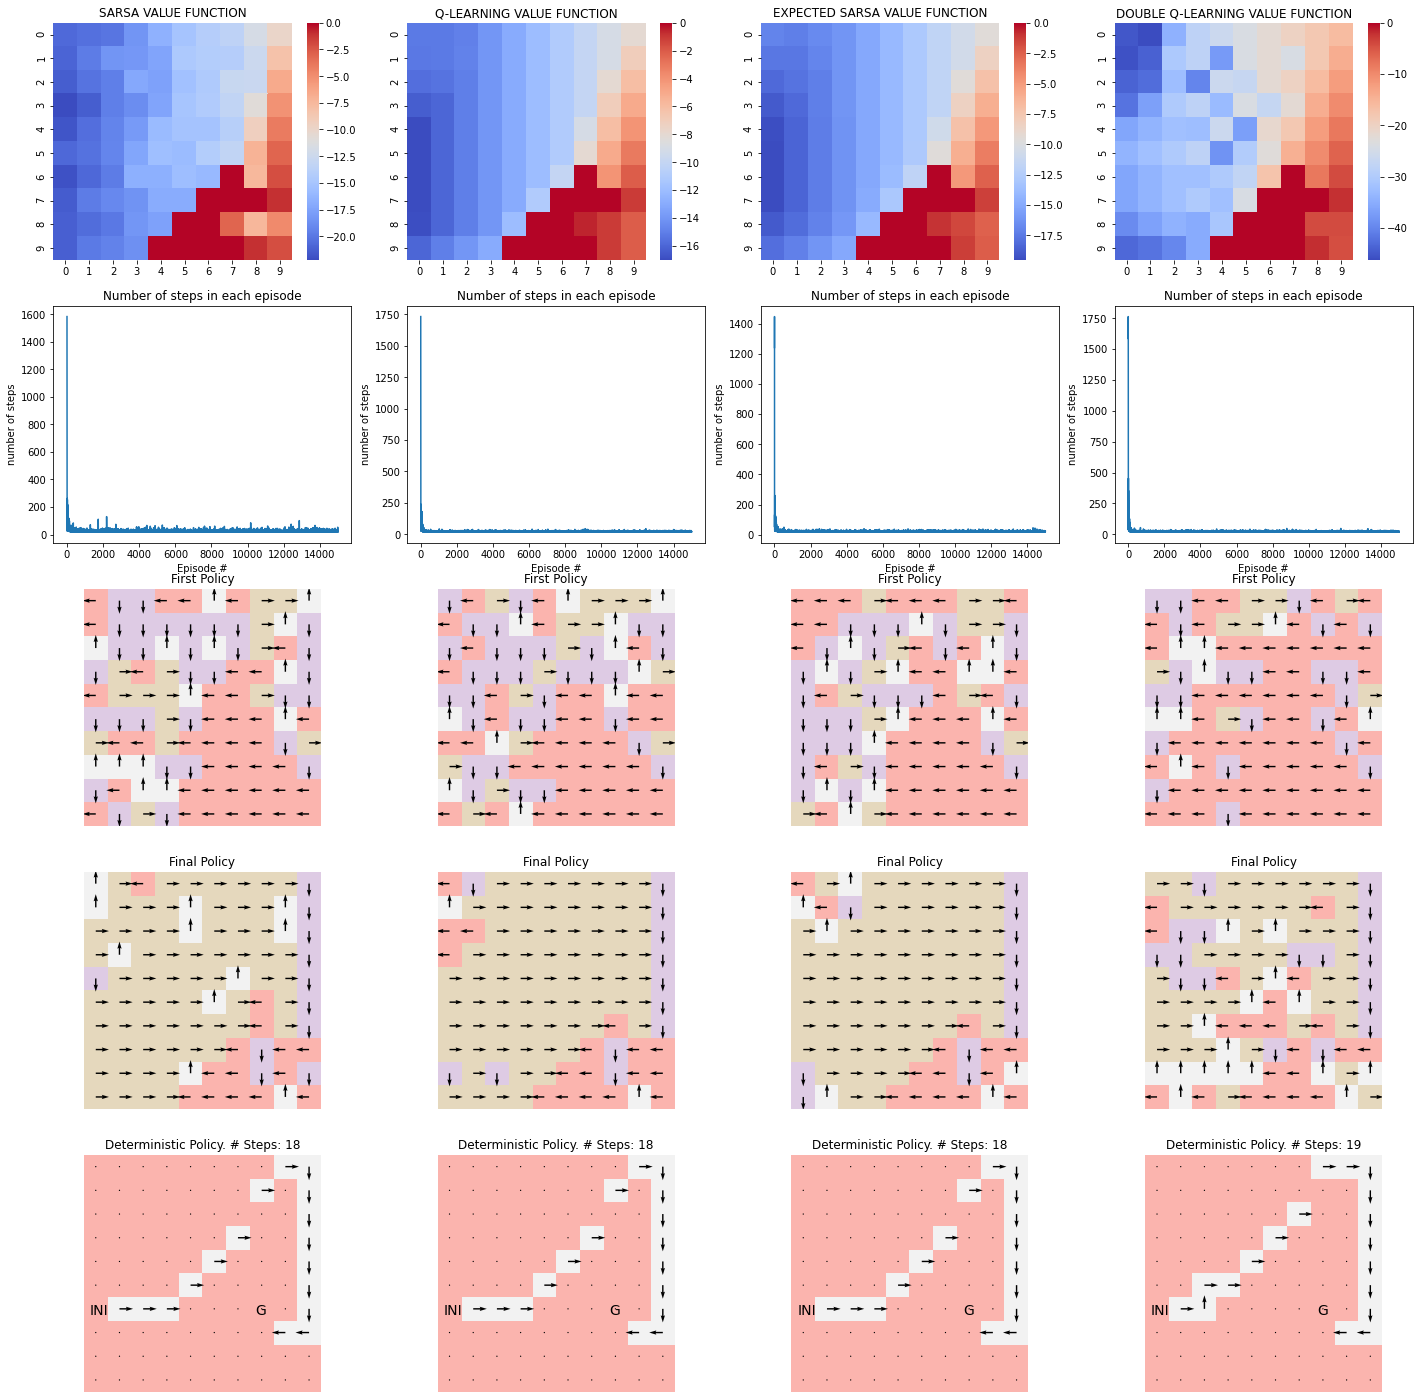

In [33]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

Podem convergir en mitja amb uns 19-20 steps. La estrategia óptima(N episodis molt gran) té 18 steps. 




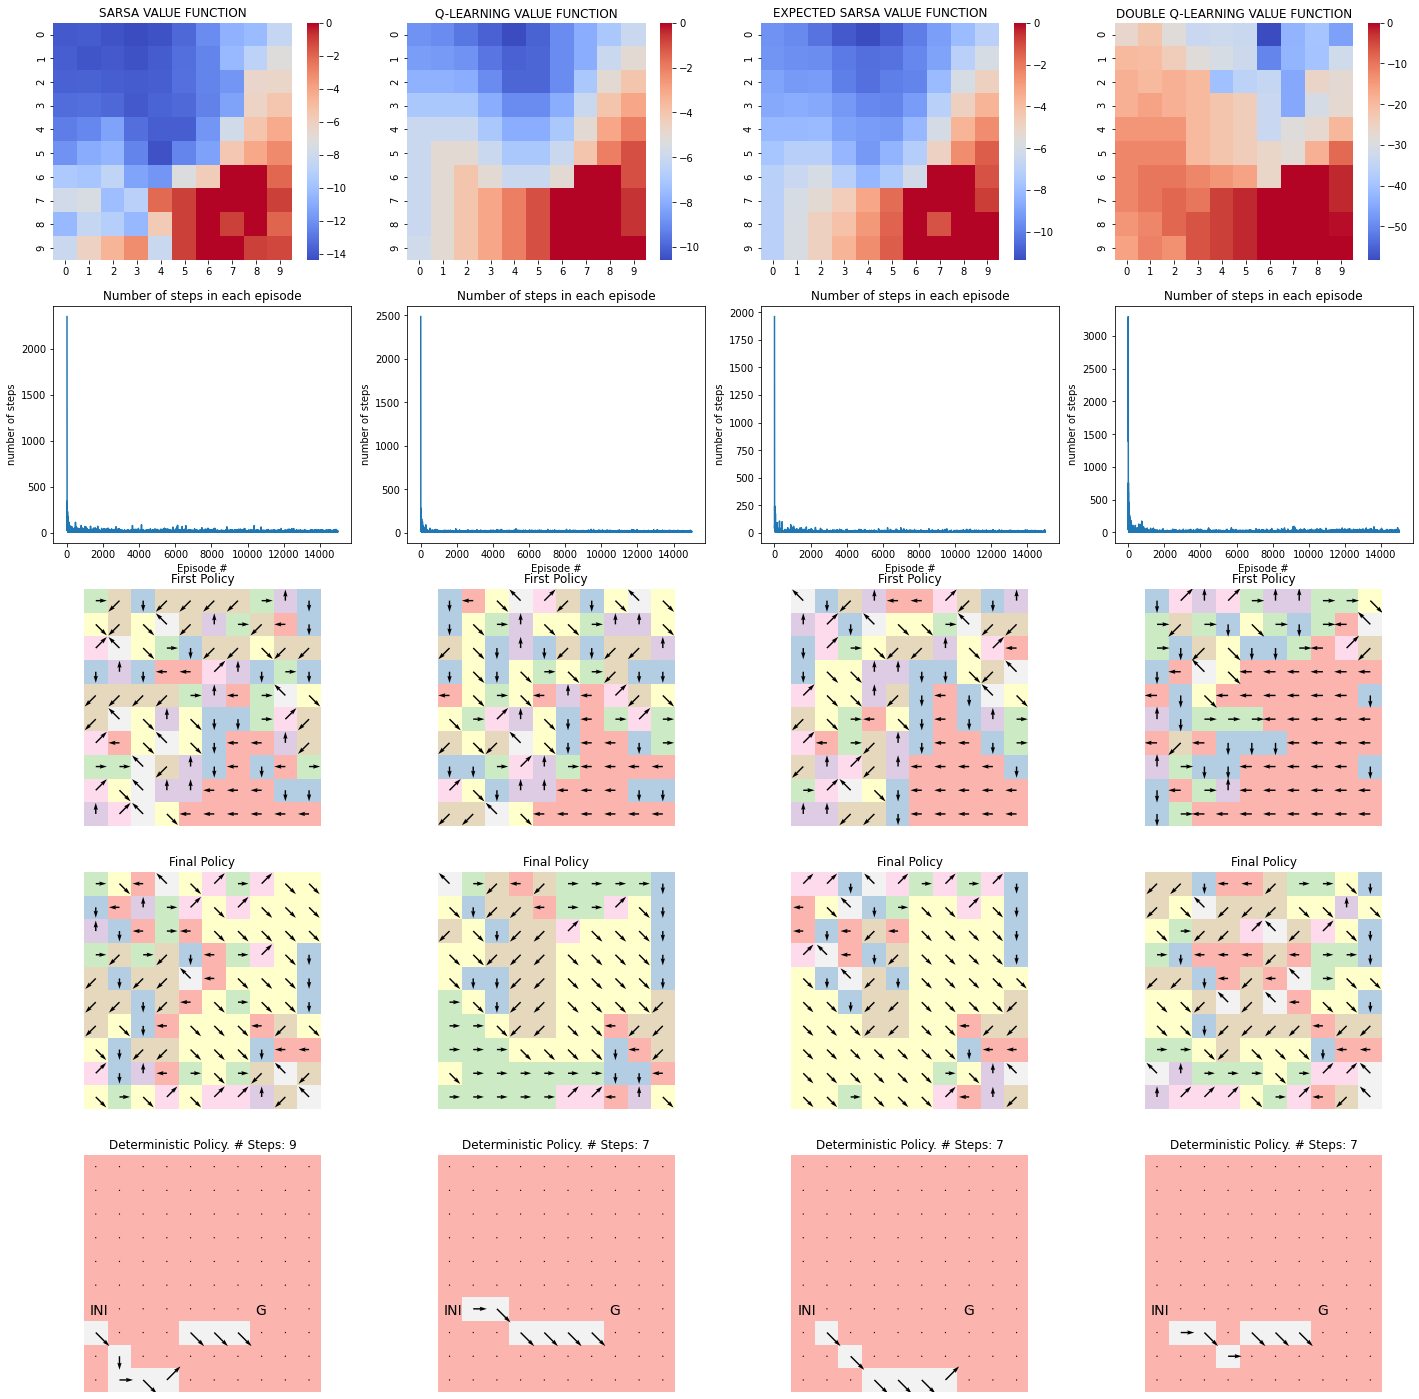

In [36]:
#EXTRA1: Diagonal wind
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

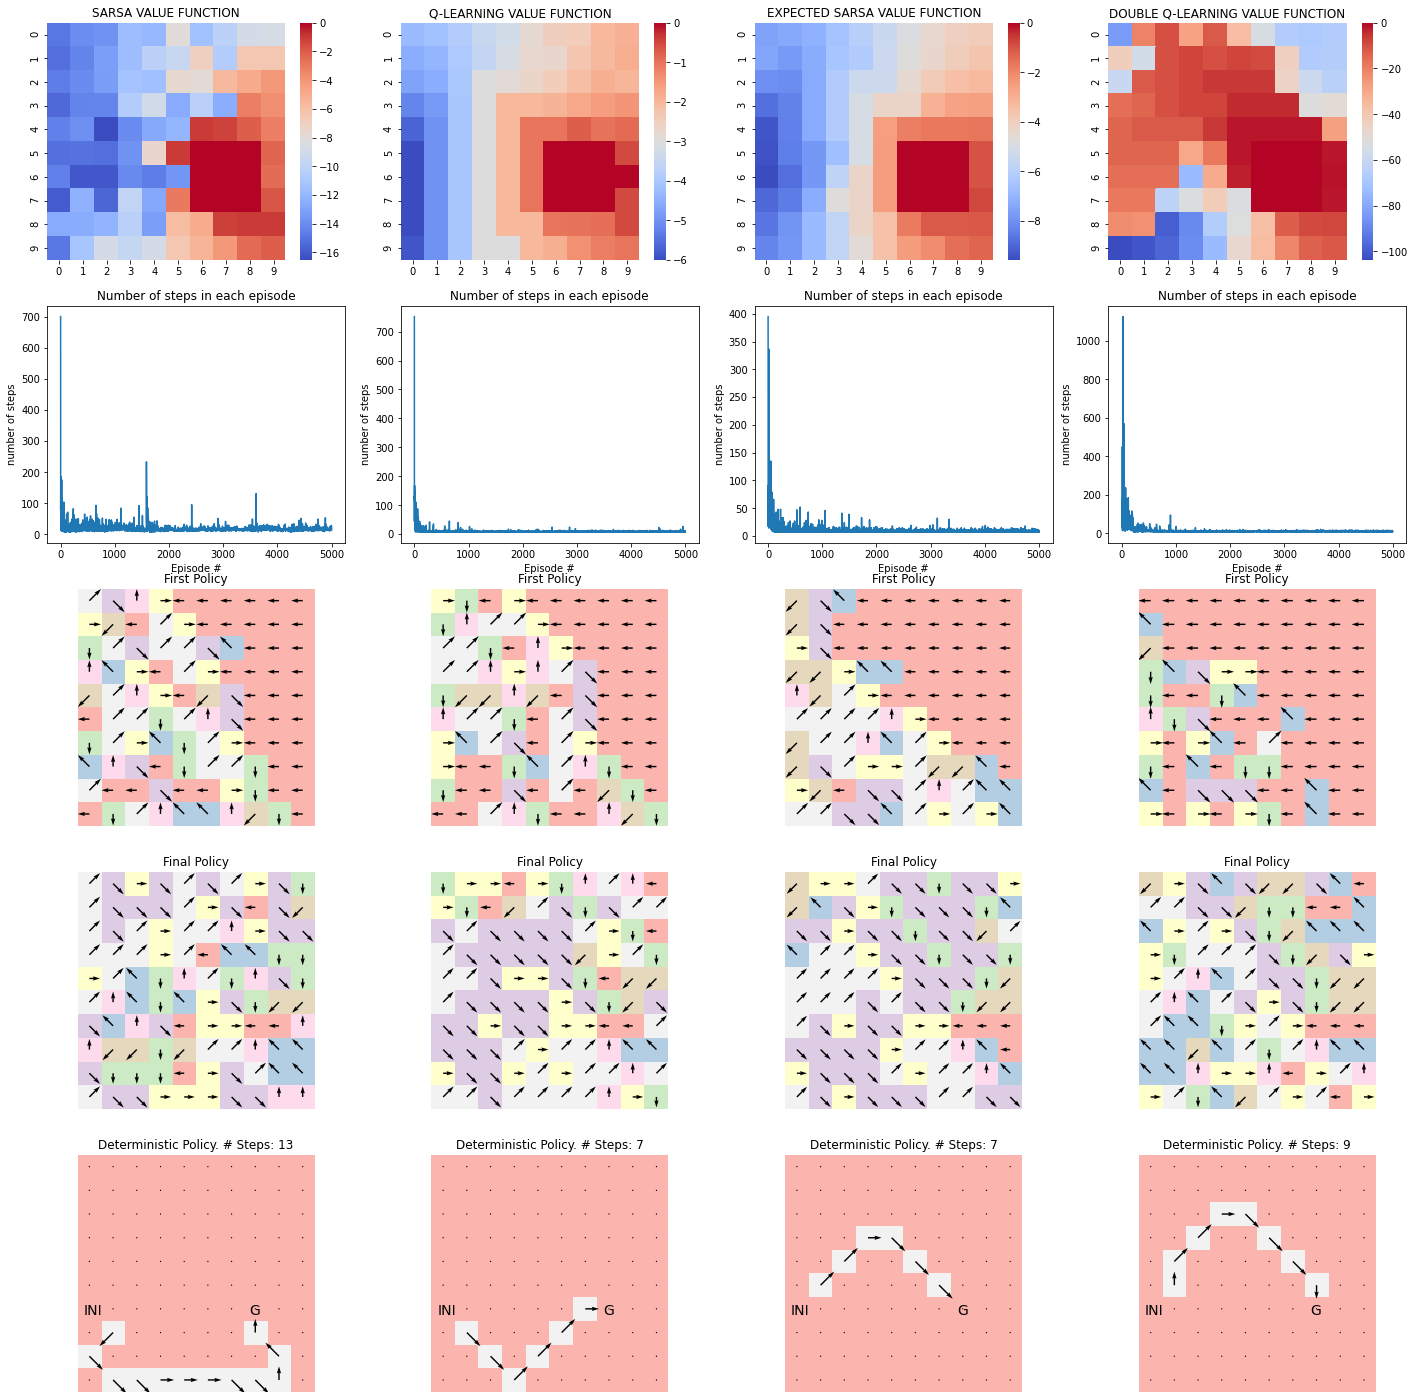

In [77]:
#EXTRA2: Cliff state at (67,45,74,55,37), with diagonal moves and no wind

general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

#Podemos ver que la policy no pasa por los cliff state y antes si lo hacía por lo tanto se ha entrenado correctamente